In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import itertools
from sklearn.preprocessing import  
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input,Dropout,Dense
from keras.models import Model
from keras import regularizers
from keras.utils.data_utils import get_file
%matplotlib inline

Loading the data: 

In [2]:
# Downloading training and test sets to local drive
try:
    training_set_path = get_file('KDDTrain%2B.csv', origin='https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv')
except:
    print('Error downloading')
    raise
    

try:
    test_set_path = get_file('KDDTest%2B.csv', origin='https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv')
except:
    print('Error downloading')
    raise
training_dataframe = pd.read_csv(training_set_path, header=None)
testing_dataframe = pd.read_csv(test_set_path, header=None)

In [3]:
training_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [4]:
testing_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


Since the CSV files don't contain a header we'll need to assign column names ourselves.

In [5]:
columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome',
    'difficulty'
]
training_dataframe.columns = columns
testing_dataframe.columns = columns

In [6]:
print("Training set has {} rows.".format(len(training_dataframe)))
print("Testing set has {} rows.".format(len(testing_dataframe)))

Training set has 125973 rows.
Testing set has 22543 rows.


In [7]:
training_outcomes=training_dataframe["outcome"].unique()
testing_outcomes=testing_dataframe["outcome"].unique()
print("The training set has {} possible outcomes \n".format(len(training_outcomes)) )
print(", ".join(training_outcomes)+".")
print("\nThe testing set has {} possible outcomes \n".format(len(testing_outcomes)))
print(", ".join(testing_outcomes)+".")

The training set has 23 possible outcomes 

normal, neptune, warezclient, ipsweep, portsweep, teardrop, nmap, satan, smurf, pod, back, guess_passwd, ftp_write, multihop, rootkit, buffer_overflow, imap, warezmaster, phf, land, loadmodule, spy, perl.

The testing set has 38 possible outcomes 

neptune, normal, saint, mscan, guess_passwd, smurf, apache2, satan, buffer_overflow, back, warezmaster, snmpgetattack, processtable, pod, httptunnel, nmap, ps, snmpguess, ipsweep, mailbomb, portsweep, multihop, named, sendmail, loadmodule, xterm, worm, teardrop, rootkit, xlock, perl, land, xsnoop, sqlattack, ftp_write, imap, udpstorm, phf.


# Extracting the labels

As depicted previously the testing set has an additional 15 attack types that are not available in training data hence we will need more general labels to train the model for the classification task.

Our model will perform binary classification of the data to two classes indicating whether the traffic is normal or an Attack.

The next section replaces the current outcome field with a Class field that has one of the following values :

Normal
Dos
R2L
U2R
Probe

In [8]:
# A list ot attack names that belong to each general attack type
dos_attacks=["snmpgetattack","back","land","neptune","smurf","teardrop","pod","apache2","udpstorm","processtable","mailbomb"]
r2l_attacks=["snmpguess","worm","httptunnel","named","xlock","xsnoop","sendmail","ftp_write","guess_passwd","imap","multihop","phf","spy","warezclient","warezmaster"]
u2r_attacks=["sqlattack","buffer_overflow","loadmodule","perl","rootkit","xterm","ps"]
probe_attacks=["ipsweep","nmap","portsweep","satan","saint","mscan"]

# Our new labels
classes=["Normal","Dos","R2L","U2R","Probe"]

#Helper function to label samples to 5 classes
def label_attack (row):
    if row["outcome"] in dos_attacks:
        return classes[1]
    if row["outcome"] in r2l_attacks:
        return classes[2]
    if row["outcome"] in u2r_attacks:
        return classes[3]
    if row["outcome"] in probe_attacks:
        return classes[4]
    return classes[0]


#We combine the datasets temporarily to do the labeling 
test_samples_length = len(testing_dataframe)
df=pd.concat([training_df,testing_dataframe])
df["Class"]=df.apply(label_attack,axis=1)


# The old outcome field is dropped since it was replaced with the Class field, the difficulty field will be dropped as well.
df=df.drop("outcome",axis=1)
df=df.drop("difficulty",axis=1)

# we again split the data into training and test sets.
training_dataframe= df.iloc[:-test_samples_length, :]
testing_dataframe= df.iloc[-test_samples_length:,:]

In [9]:
training_outcomes=training_dataframe["Class"].unique()
testing_outcomes=testing_dataframe["Class"].unique()
print("The training set has {} possible outcomes \n".format(len(training_outcomes)) )
print(", ".join(training_outcomes)+".")
print("\nThe testing set has {} possible outcomes \n".format(len(testing_outcomes)))
print(", ".join(testing_outcomes)+".")

The training set has 5 possible outcomes 

Normal, Dos, R2L, Probe, U2R.

The testing set has 5 possible outcomes 

Dos, Normal, Probe, R2L, U2R.


# Preparing the Features

In [10]:
# Helper function for scaling continous values
def minmax_scale_values(training_dataframe,testing_dataframe, col_name):
    scaler = MinMaxScaler()
    scaler = scaler.fit(training_dataframe[col_name].values.reshape(-1, 1))
    train_values_standardized = scaler.transform(training_dataframe[col_name].values.reshape(-1, 1))
    training_dataframe[col_name] = train_values_standardized
    test_values_standardized = scaler.transform(testing_dataframe[col_name].values.reshape(-1, 1))
    testing_dataframe[col_name] = test_values_standardized
    
    
#Helper function for one hot encoding
def encode_text(training_dataframe,testing_dataframe, name):
    training_set_dummies = pd.get_dummies(training_dataframe[name])
    testing_set_dummies = pd.get_dummies(testing_dataframe[name])
    for x in training_set_dummies.columns:
        dummy_name = "{}_{}".format(name, x)
        training_dataframe[dummy_name] = training_set_dummies[x]
        if x in testing_set_dummies.columns :
            testing_dataframe[dummy_name]=testing_set_dummies[x]
        else :
            testing_dataframe[dummy_name]=np.zeros(len(testing_dataframe))
    training_dataframe.drop(name, axis=1, inplace=True)
    testing_dataframe.drop(name, axis=1, inplace=True)
    
    
sympolic_columns=["protocol_type","service","flag"]
label_column="Class"
for column in df.columns :
    if column in sympolic_columns:
        encode_text(training_dataframe,testing_dataframe,column)
    elif not column == label_column:
        minmax_scale_values(training_dataframe,testing_dataframe, column)

In [11]:
training_dataframe.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
testing_dataframe.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,0.000047,9.408217e-06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.000000,1.449313e-08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.000023,0.000000e+00,1.145093e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


Next we extract the values from the pandas dataframes as Numpy arrays, where :

x holds the features of the training dataset
y holds the classification of the training dataset to one of the five possible values
x_test holds the features of the testing dataset
y_test holds the classification of the testing dataset to one of the five possible values
y0 holds the classification of the training dataset to one of two possible labels, 0 for normal traffic or 1 for an attack
y0_test holds the classification of the testing dataset to one of two possible labels, 0 for normal traffic or 1 for an attack

In [13]:
x,y=training_dataframe,training_dataframe.pop("Class").values
x=x.values
x_test,y_test=testing_dataframe,testing_dataframe.pop("Class").values
x_test=x_test.values
y0=np.ones(len(y),np.int8)
y0[np.where(y==classes[0])]=0
y0_test=np.ones(len(y_test),np.int8)
y0_test[np.where(y_test==classes[0])]=0

In [14]:
x.shape

(125973, 122)

In [15]:
x_test.shape

(22543, 122)

In [16]:
y.shape

(125973,)

In [17]:
y_test.shape

(22543,)

# The model Architecture and Training

In [18]:
#Buildling and training the model

def getModel():
    inp = Input(shape=(x.shape[1],))
    d1=Dropout(0.5)(inp)
    encoded = Dense(8, activation='relu', activity_regularizer=regularizers.l2(10e-5))(d1)
    decoded = Dense(x.shape[1], activation='relu')(encoded)
    autoencoder = Model(inp, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

autoencoder=getModel()
history=autoencoder.fit(x[np.where(y0==0)],x[np.where(y0==0)],
               epochs=10,
                batch_size=100,
                shuffle=True,
                validation_split=0.1
                       )

Epoch 1/10
607/607 [==============================] - 3s 4ms/step - loss: 0.0176 - val_loss: 0.0065
Epoch 2/10
607/607 [==============================] - 2s 4ms/step - loss: 0.0083 - val_loss: 0.0053
Epoch 3/10
607/607 [==============================] - 2s 4ms/step - loss: 0.0075 - val_loss: 0.0048
Epoch 4/10
607/607 [==============================] - 2s 3ms/step - loss: 0.0072 - val_loss: 0.0046
Epoch 5/10
607/607 [==============================] - 2s 3ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 6/10
607/607 [==============================] - 2s 3ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 7/10
607/607 [==============================] - 2s 3ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 8/10
607/607 [==============================] - 2s 3ms/step - loss: 0.0068 - val_loss: 0.0043
Epoch 9/10
607/607 [==============================] - 2s 3ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 10/10
607/607 [==============================] - 2s 4ms/step - loss: 0.0067 - val_loss: 0.0041

In [19]:
# Helper function that calculates the reconstruction loss of each data sample
def calculate_losses(x,preds):
    losses=np.zeros(len(x))
    for i in range(len(x)):
        losses[i]=((preds[i] - x[i]) ** 2).mean(axis=None)
        
    return losses

# We set the threshold equal to the training loss of the autoencoder
threshold=history.history["loss"][-1]

testing_set_predictions=autoencoder.predict(x_test)
test_losses=calculate_losses(x_test,testing_set_predictions)
testing_set_predictions=np.zeros(len(test_losses))
testing_set_predictions[np.where(test_losses>threshold)]=1

To evaluate the model we calculate the following performance metrics :

Accuracy
Recall
Precision
F1 Score
Detection rate for each of the five possible labels

In [20]:
accuracy=accuracy_score(y0_test,testing_set_predictions)
recall=recall_score(y0_test,testing_set_predictions)
precision=precision_score(y0_test,testing_set_predictions)
f1=f1_score(y0_test,testing_set_predictions)
print("Performance over the testing data set \n")
print("Accuracy : {} , Recall : {} , Precision : {} , F1 : {}\n".format(accuracy,recall,precision,f1 ))

#


for class_ in classes:
    print(class_+" Detection Rate : {}".format(len(np.where(np.logical_and(testing_set_predictions==1 , y_test==class_))[0])/len(np.where(y_test==class_)[0])))


Performance over the testing data set 

Accuracy : 0.9030297653373552 , Recall : 0.9618951141588094 , Precision : 0.8791396624172068 , F1 : 0.9186574384163132

Normal Detection Rate : 0.17476828012358395
Dos Detection Rate : 0.9414614981665793
R2L Detection Rate : 0.9856035437430787
U2R Detection Rate : 0.9552238805970149
Probe Detection Rate : 1.0


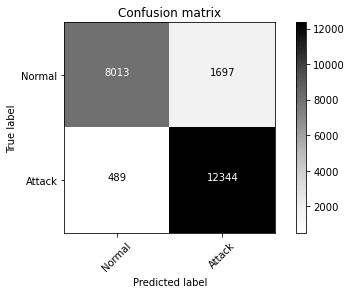

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
c = confusion_matrix(y0_test,testing_set_predictions)
plot_confusion_matrix(c,["Normal","Attack"])


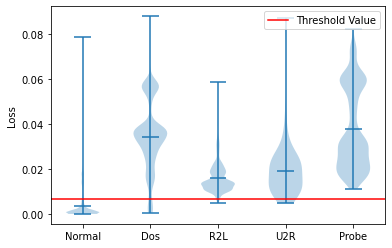

In [22]:
plt.ylabel('Loss')
plt.xticks(np.arange(0,5), classes)
plt.violinplot([test_losses[np.where(y_test==class_)] for class_ in classes],np.arange(0,len(classes)),showmeans =True )
plt.axhline(y=threshold,c='r',label="Threshold Value")
plt.legend();